# Permutation test: spatial similarity

### Reading in the maps and values

In [41]:
import pandas as pd
import numpy as np
efvol_sid_hamd2 = pd.read_csv('/resources/ANALYSIS/Efvol_N386.csv')
Xlong=efvol_sid_hamd2[['Record ID', 'roi','ef_mix3','volume change','age', 'Hamd change percent','pmnt','nECT']].iloc[np.where(efvol_sid_hamd2['pmnt']==0)]
Xwide=pd.pivot(Xlong, index='Record ID', columns= 'roi', values=['ef_mix3','volume change'])
Xw = Xwide.merge(Xlong[['Record ID', 'age', 'Hamd change percent','pmnt', 'nECT']].drop_duplicates(), on='Record ID').dropna()
orreg_t = [i[1] for i in Xw.columns[1:86]]
orreg = pd.DataFrame(orreg_t).astype(str)[0].str.replace('_','-')
#orreg

import numpy as np


siddiqi_table = np.loadtxt('/resources/Siddiqi/Desikan-Killiany-Atlas-Siddiqi_2021_NHB_CombinedMap.txt', dtype="i1,i1,i4,f4,S32,f4,f4,f4,f4,f4")
#ef_table = fs.read_label('/input/EF_ALL/Roast30/G100104/RUL-ALL-01-EF_MAGN_result.txt')
#pd.DataFrame(ef_table, columns=['index', 'segid', 'nvox', 'volmm3', 'structure_name', 'ef_mean', 'ef_std', 'ef_min', 'ef_max', 'ef_range'],  dtype="i1,i1,i4,f4,S32,f4,f4,f4,f4,f4")
siddiqi_df = pd.DataFrame(siddiqi_table)
siddiqi_df.columns=['index', 'segid', 'nvox', 'volmm3', 'structure_name', 's_mean', 's_std', 's_min', 's_max', 's_range']
#siddiqi_df['structure_name'].iloc[5]
siddiqi_df['roi'] = siddiqi_df['structure_name'].str.decode(encoding='UTF-8').str.replace("-","_").str.replace("_Proper","")
#siddiqi_df.iloc[42:90]

#Plotting
roi=orreg[0]
#for i,roi in enumerate(orreg):
#ix = np.where(siddiqi_df['structure_name']==roi)
#print(ix)
slist = []
rl = np.array([siddiqi_df['structure_name'][i].decode('UTF-8') for i in range(0,siddiqi_df.shape[0])])
rl2 = pd.DataFrame(rl).replace('Left-Thalamus-Proper','Left-Thalamus').replace('Right-Thalamus-Proper','Right-Thalamus')
for i,roi in enumerate(orreg):
    ix = np.where(rl2==roi)
    if (len(ix[0]) != 0): 
        #print(ix[0][0])
        slist.append(siddiqi_df['s_mean'].iloc[ix[0][0]])
svec =  np.array(slist)
svec.shape

/tmp/ipykernel_25/2780448308.py:6: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  Xw = Xwide.merge(Xlong[['Record ID', 'age', 'Hamd change percent','pmnt', 'nECT']].drop_duplicates(), on='Record ID').dropna()


(85,)

In [293]:
#ba.columns[3:].str.replace('_change','')
res=pd.read_csv('/resources/roicoordinates.csv')
res['absx']=abs(res['x'])
res['r_o_i'] = res['roi'].str.replace('-','_').replace('Left_Thalamus','Left_Thalamus_Proper').replace('Right_Thalamus','Right_Thalamus_Proper')
res=res.set_index('r_o_i')
res = res.reindex(index=ba.columns[3:].str.replace('_change',''))
res = res.reset_index()
#res

## Volume Change

### Permutation test version 1
Here we randomly reassign DeltaVOL_ij to DeltaVOL_ik where i is the ith ROI and j and k is the jth and kth subject. We do this reassignment independntly in all 85 regions. Then we calculate PCA, we repeat it 1000 times and build a distribution that can be used to make statistical inference. 

In [288]:
#gli

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from scipy.stats import spearmanr

gli=np.array(range(0,85))
biglist1=[]
for k in range(2): #PC1 or PC2
    for pp in range(3): #this is the placement 0 RUL 1 BT 2 MIX
        clist = gli+85
        pcacomp=2
        #eflist = np.append(np.array(range(0,85)),170)
        eflist = np.array(range(0,85))
        pcloads = np.empty((len(gli),0),float)
        pcs = []
        adat = []
        outcome = []
        strloads=[]
        recordids=[]

        Xlong=efvol_sid_hamd2[['Record ID', 'roi','ef_mix3','volume change','age', 'Hamd change percent','pmnt','nECT']].iloc[np.where(efvol_sid_hamd2['pmnt']==pp)]
        Xwide=pd.pivot(Xlong, index='Record ID', columns= 'roi', values=['ef_mix3','volume change'])
        Xw = Xwide.merge(Xlong[['Record ID', 'age', 'Hamd change percent','pmnt', 'nECT']].drop_duplicates(), on='Record ID').dropna()
        recordids.append(Xw.iloc[:,0].values)
        X=Xw.iloc[:,1:(Xw.shape[1]-4)].values
        X_train=X[:,clist]
        #y =Xw.iloc[:,(Xw.shape[1]-4):Xw.shape[1]].values
        sc=StandardScaler()
        X_train = sc.fit_transform(X_train)
        #X_train.std(axis=0)
        #Xlater = X_train.copy()
        #adat.append(Xlater)
        pca = PCA(n_components = pcacomp)
        X_train = pca.fit_transform(X_train)
        rvalues_real=abs(pearsonr(pca.components_[k,:],svec[gli])[0])
        #rvalues_real=abs(spearmanr(pca.components_[k,:],svec[gli])[0])
        rvalues = []
        for j in range(1000):
            X_train=X[:,clist]
            NR = X_train.shape[1]
            for i in range(NR):
                ix = np.random.permutation(X_train.shape[0])
                X_train[:,i] = X_train[ix,i]
            sc=StandardScaler()
            X_train = sc.fit_transform(X_train)
            #X_train.std(axis=0)
            #Xlater = X_train.copy()
            #adat.append(Xlater)
            pca = PCA(n_components = pcacomp)
            X_train = pca.fit_transform(X_train)
            rvalues.append(abs(pearsonr(pca.components_[k,:],svec[gli])[0]))#pc is well defined only to a -1 so we need absolute
            #pca.components_[k,:]
        biglist1.append(list(rvalues))
        biglist1.append(rvalues_real)

/tmp/ipykernel_25/3108936441.py:26: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  Xw = Xwide.merge(Xlong[['Record ID', 'age', 'Hamd change percent','pmnt', 'nECT']].drop_duplicates(), on='Record ID').dropna()
/tmp/ipykernel_25/3108936441.py:26: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  Xw = Xwide.merge(Xlong[['Record ID', 'age', 'Hamd change percent','pmnt', 'nECT']].drop_duplicates(), on='Record ID').dropna()
/tmp/ipykernel_25/3108936441.py:26: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  Xw = Xwide.merge(Xlong[['Record ID', 'age', 'Hamd change percent','pmnt', 'nECT']].drop_duplicates(), on='Record ID').dropna()
/tmp/ipykernel_25/3108936441.py:26: FutureWarning: merging between different le

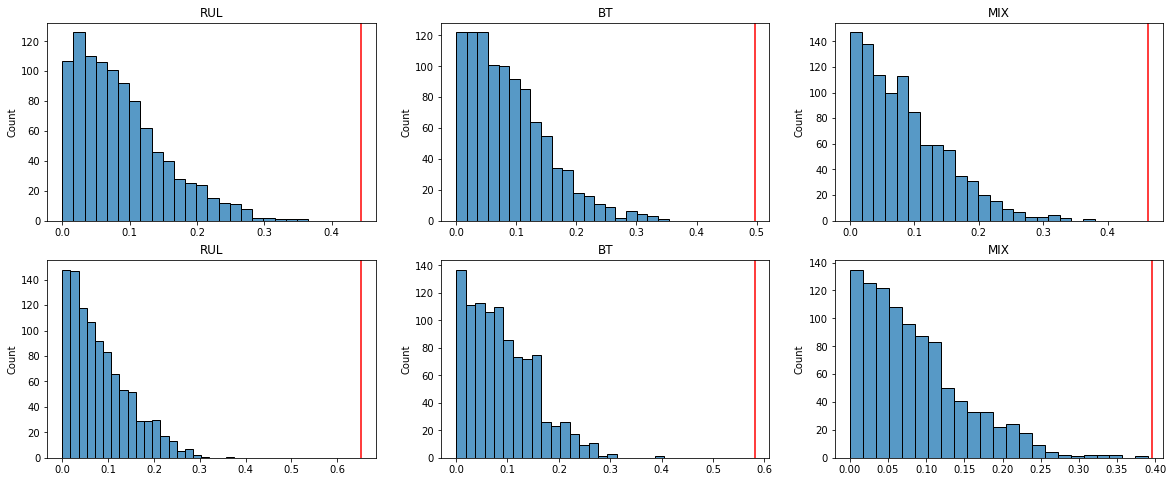

In [289]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axs = plt.subplot_mosaic("XYZ;ABC", figsize=(20,8))
figpl = ['X','Y', 'Z','A','B','C']
mypmnt = ['RUL', 'BT', 'MIX','RUL', 'BT', 'MIX']
for j in range(6):
    _ = sns.histplot(biglist1[2*j], ax=axs[figpl[j]])
    axs[figpl[j]].axvline(biglist1[2*j+1],0,10, color='red')
    axs[figpl[j]].set_title(mypmnt[j])

### PC1 vs PC2 in a multiple regression

In [345]:
#gli

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from scipy.stats import spearmanr

gli=np.array(range(0,85))
biglist15=[]
#for k in range(2): #PC1 or PC2
for pp in range(3): #this is the placement 0 RUL 1 BT 2 MIX
    clist = gli+85
    pcacomp=2
    #eflist = np.append(np.array(range(0,85)),170)
    eflist = np.array(range(0,85))
    pcloads = np.empty((len(gli),0),float)
    pcs = []
    adat = []
    outcome = []
    strloads=[]
    recordids=[]

    Xlong=efvol_sid_hamd2[['Record ID', 'roi','ef_mix3','volume change','age', 'Hamd change percent','pmnt','nECT']].iloc[np.where(efvol_sid_hamd2['pmnt']==pp)]
    Xwide=pd.pivot(Xlong, index='Record ID', columns= 'roi', values=['ef_mix3','volume change'])
    Xw = Xwide.merge(Xlong[['Record ID', 'age', 'Hamd change percent','pmnt', 'nECT']].drop_duplicates(), on='Record ID').dropna()
    recordids.append(Xw.iloc[:,0].values)
    X=Xw.iloc[:,1:(Xw.shape[1]-4)].values
    X_train=X[:,clist]
    #y =Xw.iloc[:,(Xw.shape[1]-4):Xw.shape[1]].values
    sc=StandardScaler()
    X_train = sc.fit_transform(X_train)
    #X_train.std(axis=0)
    #Xlater = X_train.copy()
    #adat.append(Xlater)
    pca = PCA(n_components = pcacomp)
    X_train = pca.fit_transform(X_train)
    #rvalues_real=abs(pearsonr(pca.components_[k,:],svec[gli])[0])
    #rvalues_real=abs(spearmanr(pca.components_[k,:],svec[gli])[0])
    #rvalues = []
    res['perm1']=pca.components_[0,:]
    res['perm2']=pca.components_[1,:]
    mpc1=pca.components_[0,:]
    mpc2=pca.components_[1,:]
    #X=res[['absx','y','z','perm1','perm2']]
    #XX=res[['perm1','perm2','absx','y','z']]
    XX=res[['perm1','perm2']]
    #X=res[[name[kk],'absx','y','z']]
    y=res['sid']
    XX = sm.add_constant(XX)
    model = sm.OLS(y,XX).fit()
    predictions = model.predict(XX)
    rv1=(abs(model.tvalues[1]))
    rv2=(abs(model.tvalues[2]))
    perm1=[]
    perm2=[]
    for g in range(2):
        for j in range(1000):
            X_train=X[:,clist]
            NR = X_train.shape[1]
            for i in range(NR):
                ix = np.random.permutation(X_train.shape[0])
                X_train[:,i] = X_train[ix,i]
            sc=StandardScaler()
            X_train = sc.fit_transform(X_train)
            #X_train.std(axis=0)
            #Xlater = X_train.copy()
            #adat.append(Xlater)
            pca = PCA(n_components = pcacomp)
            X_train = pca.fit_transform(X_train)
            #rvalues.append(abs(spearmanr(pca.components_[k,:],svec[gli])[0]))#pc is well defined only to a -1 so we need absolute
            #pca.components_[k,:]
            if (g==0):
                res['perm1']=pca.components_[0,:]
                res['perm2']=mpc2
            else:
                res['perm2']=pca.components_[1,:]
                res['perm1']=mpc1
            #X=res[['absx','y','z','perm1','perm2']]
            #XX=res[['perm1','perm2','absx','y','z']]
            XX=res[['perm1','perm2']]
            #X=res[[name[kk],'absx','y','z']]
            y=res['sid']
            XX = sm.add_constant(XX)
            model = sm.OLS(y,XX).fit()
            predictions = model.predict(XX)
            if (g==0):
                perm1.append(abs(model.tvalues[1]))
            else:
                perm2.append(abs(model.tvalues[2]))
    biglist15.append(list(perm1))
    biglist15.append(rv1)
    biglist15.append(list(perm2))
    biglist15.append(rv2)
    
    

/tmp/ipykernel_25/1963287519.py:26: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  Xw = Xwide.merge(Xlong[['Record ID', 'age', 'Hamd change percent','pmnt', 'nECT']].drop_duplicates(), on='Record ID').dropna()
/tmp/ipykernel_25/1963287519.py:26: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  Xw = Xwide.merge(Xlong[['Record ID', 'age', 'Hamd change percent','pmnt', 'nECT']].drop_duplicates(), on='Record ID').dropna()
/tmp/ipykernel_25/1963287519.py:26: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  Xw = Xwide.merge(Xlong[['Record ID', 'age', 'Hamd change percent','pmnt', 'nECT']].drop_duplicates(), on='Record ID').dropna()


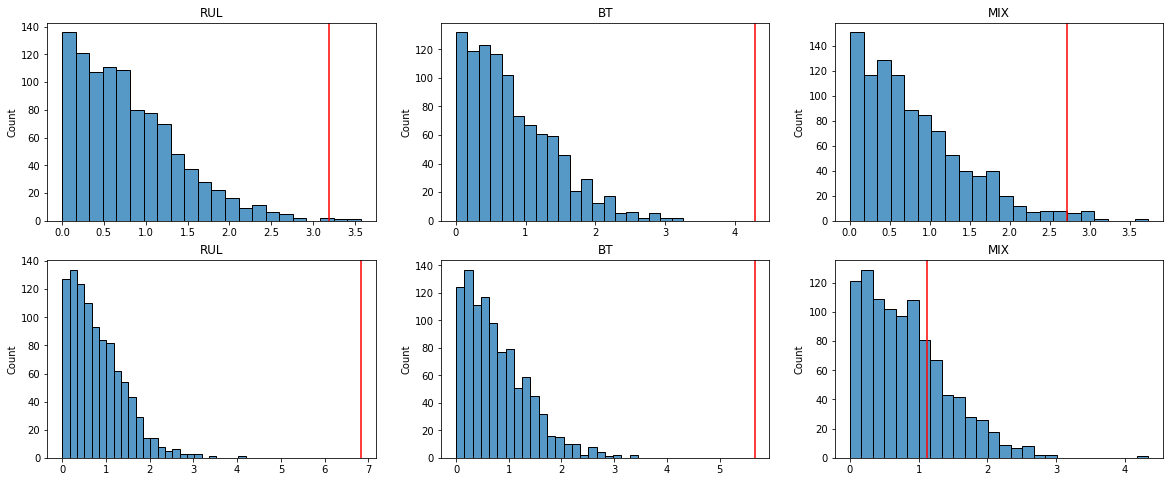

In [346]:
fig, axs = plt.subplot_mosaic("XYZ;ABC", figsize=(20,8))
figpl = ['X','A','Y','B','Z','C']
mypmnt = ['RUL','RUL', 'BT',  'BT', 'MIX','MIX']
for j in range(6):
    _ = sns.histplot(biglist15[2*j], ax=axs[figpl[j]])
    axs[figpl[j]].axvline(biglist15[2*j+1],0,10, color='red')
    axs[figpl[j]].set_title(mypmnt[j])


In [ ]:
for j in range(6):
    print(1- np.where(biglist15[2*j]<biglist15[2*j+1])[0].shape[0]/1000)

### XYZ

In [348]:
#gli

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from scipy.stats import spearmanr

gli=np.array(range(0,85))
biglist15=[]
#for k in range(2): #PC1 or PC2
for pp in range(3): #this is the placement 0 RUL 1 BT 2 MIX
    clist = gli+85
    pcacomp=2
    #eflist = np.append(np.array(range(0,85)),170)
    eflist = np.array(range(0,85))
    pcloads = np.empty((len(gli),0),float)
    pcs = []
    adat = []
    outcome = []
    strloads=[]
    recordids=[]

    Xlong=efvol_sid_hamd2[['Record ID', 'roi','ef_mix3','volume change','age', 'Hamd change percent','pmnt','nECT']].iloc[np.where(efvol_sid_hamd2['pmnt']==pp)]
    Xwide=pd.pivot(Xlong, index='Record ID', columns= 'roi', values=['ef_mix3','volume change'])
    Xw = Xwide.merge(Xlong[['Record ID', 'age', 'Hamd change percent','pmnt', 'nECT']].drop_duplicates(), on='Record ID').dropna()
    recordids.append(Xw.iloc[:,0].values)
    X=Xw.iloc[:,1:(Xw.shape[1]-4)].values
    X_train=X[:,clist]
    #y =Xw.iloc[:,(Xw.shape[1]-4):Xw.shape[1]].values
    sc=StandardScaler()
    X_train = sc.fit_transform(X_train)
    #X_train.std(axis=0)
    #Xlater = X_train.copy()
    #adat.append(Xlater)
    pca = PCA(n_components = pcacomp)
    X_train = pca.fit_transform(X_train)
    #rvalues_real=abs(pearsonr(pca.components_[k,:],svec[gli])[0])
    #rvalues_real=abs(spearmanr(pca.components_[k,:],svec[gli])[0])
    #rvalues = []
    res['perm1']=pca.components_[0,:]
    res['perm2']=pca.components_[1,:]
    mpc1=pca.components_[0,:]
    mpc2=pca.components_[1,:]
    #X=res[['absx','y','z','perm1','perm2']]
    XX=res[['perm1','perm2','absx','y','z']]
    #XX=res[['perm1','perm2']]
    #X=res[[name[kk],'absx','y','z']]
    y=res['sid']
    XX = sm.add_constant(XX)
    model = sm.OLS(y,XX).fit()
    predictions = model.predict(XX)
    rv1=(abs(model.tvalues[1]))
    rv2=(abs(model.tvalues[2]))
    perm1=[]
    perm2=[]
    for g in range(2):
        for j in range(1000):
            X_train=X[:,clist]
            NR = X_train.shape[1]
            for i in range(NR):
                ix = np.random.permutation(X_train.shape[0])
                X_train[:,i] = X_train[ix,i]
            sc=StandardScaler()
            X_train = sc.fit_transform(X_train)
            #X_train.std(axis=0)
            #Xlater = X_train.copy()
            #adat.append(Xlater)
            pca = PCA(n_components = pcacomp)
            X_train = pca.fit_transform(X_train)
            #rvalues.append(abs(spearmanr(pca.components_[k,:],svec[gli])[0]))#pc is well defined only to a -1 so we need absolute
            #pca.components_[k,:]
            if (g==0):
                res['perm1']=pca.components_[0,:]
                res['perm2']=mpc2
            else:
                res['perm2']=pca.components_[1,:]
                res['perm1']=mpc1
            #X=res[['absx','y','z','perm1','perm2']]
            XX=res[['perm1','perm2','absx','y','z']]
            #XX=res[['perm1','perm2']]
            #X=res[[name[kk],'absx','y','z']]
            y=res['sid']
            XX = sm.add_constant(XX)
            model = sm.OLS(y,XX).fit()
            predictions = model.predict(XX)
            if (g==0):
                perm1.append(abs(model.tvalues[1]))
            else:
                perm2.append(abs(model.tvalues[2]))
    biglist15.append(list(perm1))
    biglist15.append(rv1)
    biglist15.append(list(perm2))
    biglist15.append(rv2)
    
    

/tmp/ipykernel_25/943402635.py:26: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  Xw = Xwide.merge(Xlong[['Record ID', 'age', 'Hamd change percent','pmnt', 'nECT']].drop_duplicates(), on='Record ID').dropna()
/tmp/ipykernel_25/943402635.py:26: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  Xw = Xwide.merge(Xlong[['Record ID', 'age', 'Hamd change percent','pmnt', 'nECT']].drop_duplicates(), on='Record ID').dropna()
/tmp/ipykernel_25/943402635.py:26: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  Xw = Xwide.merge(Xlong[['Record ID', 'age', 'Hamd change percent','pmnt', 'nECT']].drop_duplicates(), on='Record ID').dropna()


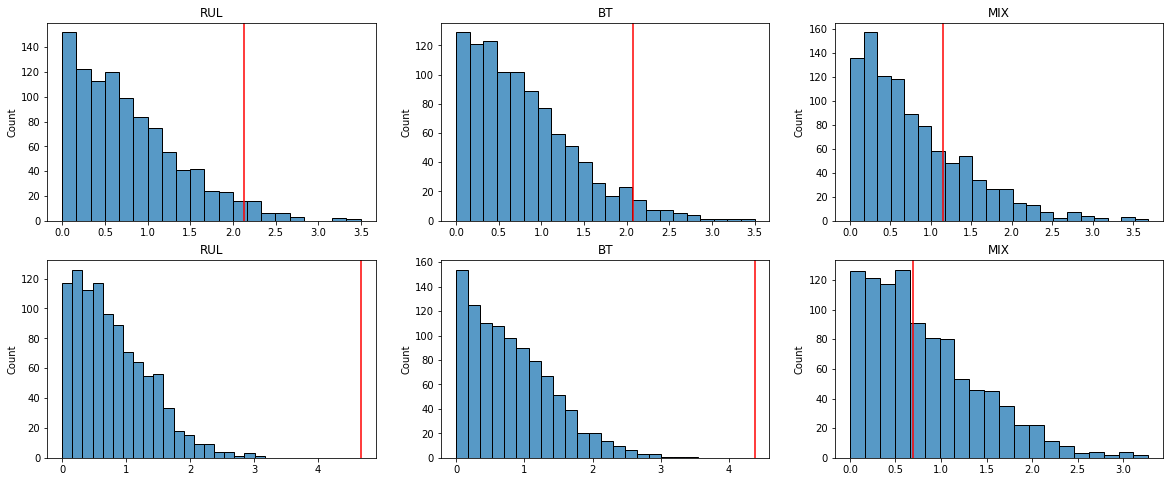

In [350]:
fig, axs = plt.subplot_mosaic("XYZ;ABC", figsize=(20,8))
figpl = ['X','A','Y','B','Z','C']
mypmnt = ['RUL','RUL', 'BT',  'BT', 'MIX','MIX']
for j in range(6):
    _ = sns.histplot(biglist15[2*j], ax=axs[figpl[j]])
    axs[figpl[j]].axvline(biglist15[2*j+1],0,10, color='red')
    axs[figpl[j]].set_title(mypmnt[j])

In [351]:
for j in range(6):
    print(1- np.where(biglist15[2*j]<biglist15[2*j+1])[0].shape[0]/1000)

0.03500000000000003
0.0
0.041000000000000036
0.0
0.252
0.494


### Permutation test version 2 - based on the reviewer suggestion - only can be applied to volume change

We had the baseline volume image and the post ECT image and we randomly reassigned the baseline to different individuals and calculated this randolmly shuffeled volume changes and corresponding PCAs

In [49]:
#to do the recommended review wise...

ectdf = pd.read_csv('/resources/ANALYSIS/ECT_DATA_LABELS_2022-06-14_1917.csv')
#for i, col in enumerate(ectdf.columns):
#    print(col)

ixs = []
for i,col in enumerate(orreg):
    ix = np.where(ectdf.columns == col.replace('-','_').replace('Thalamus','Thalamus_Proper')+'_baseline')
    if len(ix[0])>0:
        #print(orreg[ix[0]])
        ixs.append(ix[0][0])
mc= ['Record ID', 'Event Name'] + ectdf.columns[ixs].values.tolist()
baseline_vol = ectdf[mc].iloc[np.where(ectdf['Event Name']=='after_treatment')]
baseline_vol
mb = ectdf.columns[ixs].values.tolist()

ixs = []
for i,col in enumerate(orreg):
    ix = np.where(ectdf.columns == col.replace('-','_').replace('Thalamus','Thalamus_Proper')+'_change')
    if len(ix[0])>0:
        #print(orreg[ix[0]])
        ixs.append(ix[0][0])
mc= ['Record ID', 'Event Name'] + ectdf.columns[ixs].values.tolist()
change_vol = ectdf[mc].iloc[np.where(ectdf['Event Name']=='after_treatment')]
change_vol
mc = ectdf.columns[ixs].values.tolist()

#we use the fact that the order of the rois is identical
#change= 2*(vol2-vol1)/(vol2+vol1)
#comes: v2 = (1+2c)*v1/(1-2c)
basvol = baseline_vol.copy()
basvol.columns= ['Record ID', 'Event Name'] +mc
#basvol# name should not fool you
post_vol= change_vol[['Record ID', 'Event Name']].join(((1+2*change_vol.loc[:,mc])/(1-2*change_vol.loc[:,mc]))*basvol.loc[:,mc])
#post_vol
#((1+2*change_vol.loc[:,mc])/(1-2*change_vol.loc[:,mc]))*basvol.loc[:,mc]

/tmp/ipykernel_25/3629963977.py:3: DtypeWarning: Columns (13,35,36,37,52,104,163,167,174,176) have mixed types. Specify dtype option on import or set low_memory=False.
  ectdf = pd.read_csv('/resources/ANALYSIS/ECT_DATA_LABELS_2022-06-14_1917.csv')


##### here we chose first the placement

In [290]:
biglist2=[]
for kk in range(2): #PC1 or PC2
    for pp in range(3): #this is the placement 0 RUL 1 BT 2 MIX
        po = post_vol.iloc[np.where(post_vol['Record ID'].isin(efvol_sid_hamd2['Record ID'].iloc[np.where(efvol_sid_hamd2['pmnt']==pp)].unique()))].reset_index().copy()
        ba = basvol.iloc[np.where(basvol['Record ID'].isin(efvol_sid_hamd2['Record ID'].iloc[np.where(efvol_sid_hamd2['pmnt']==pp)].unique()))].reset_index().copy()


        #ba and po 
        rvalues=[]
        for k in range(1000):
            ix = np.random.permutation(po.shape[0])
            #ix=range(246)
            X_train = 2*(np.array(po.loc[:,mc])-np.array(ba.loc[ix,mc])[ix,:])/(np.array(po.loc[:,mc])+np.array(ba.loc[:,mc])[ix,:])

            #X_train = np.array(2*(po.loc[:,mc]-ba.loc[ix,mc])/(po.loc[:,mc]+ba.loc[ix,mc]))
            X_train

            pcacomp=2
            #eflist = np.append(np.array(range(0,85)),170)
            eflist = np.array(range(0,85))
            pcloads = np.empty((len(gli),0),float)
            pcs = []
            adat = []
            outcome = []
            strloads=[]
            recordids=[]
            sc=StandardScaler()
            X_train = sc.fit_transform(X_train)
            #X_train.std(axis=0)
            #Xlater = X_train.copy()
            #adat.append(Xlater)
            pca = PCA(n_components = pcacomp)
            X_train = pca.fit_transform(X_train)
            #rvalues.append(abs(pearsonr(pca.components_[kk,:],svec[gli])[0]))#abs is needed as the pc sign is not well defined
            rvalues.append(abs(pearsonr(pca.components_[kk,:],svec[gli])[0]))#abs is needed as the pc sign is not well defined
            #rvalues_real #we get the original
        biglist2.append(list(rvalues))
        #biglist2.append(rvalues_real)

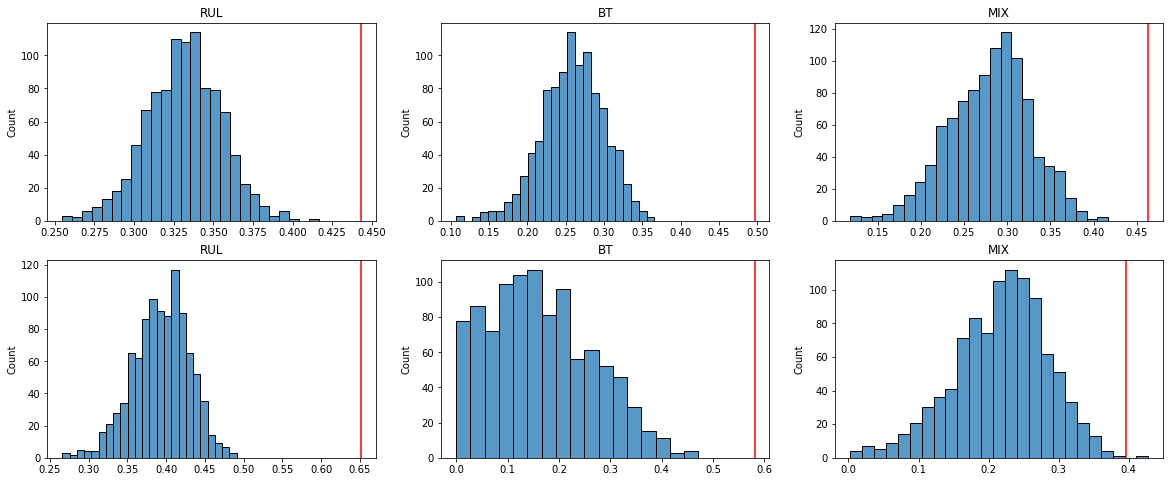

In [291]:
fig, axs = plt.subplot_mosaic("XYZ;ABC", figsize=(20,8))
figpl = ['X','Y', 'Z','A','B','C']
mypmnt = ['RUL', 'BT', 'MIX','RUL', 'BT', 'MIX']
for j in range(6):
    _ = sns.histplot(biglist2[j], ax=axs[figpl[j]])#here we just stored the permutations
    axs[figpl[j]].axvline(biglist1[2*j+1],0,10, color='red')#we use the real value from earlier
    axs[figpl[j]].set_title(mypmnt[j])

In [292]:
for j in range(6):
    print(biglist1[2*j+1])

0.44300175515241763
0.49641513941676046
0.46334609552325823
0.6508678978312301
0.5806128807319512
0.39614491555133


### Permutation of the pc values and calculating t

In [352]:
import statsmodels.api as sm


name = ['perm1', 'perm2']

biglist3=[]

for pp in range(3): #this is the placement 0 RUL 1 BT 2 MIX
    #for kk in range(2):#PC1 and PC2
        po = post_vol.iloc[np.where(post_vol['Record ID'].isin(efvol_sid_hamd2['Record ID'].iloc[np.where(efvol_sid_hamd2['pmnt']==pp)].unique()))].reset_index().copy()
        ba = basvol.iloc[np.where(basvol['Record ID'].isin(efvol_sid_hamd2['Record ID'].iloc[np.where(efvol_sid_hamd2['pmnt']==pp)].unique()))].reset_index().copy()


        #ba and po 
        
        perm1=[]
        perm2=[]
        for g in range(2):
            for k in range(1000):
                ix = np.random.permutation(po.shape[0])
                #ix=range(246)
                X_train = 2*(np.array(po.loc[:,mc])-np.array(ba.loc[ix,mc])[ix,:])/(np.array(po.loc[:,mc])+np.array(ba.loc[:,mc])[ix,:])

                #X_train = np.array(2*(po.loc[:,mc]-ba.loc[ix,mc])/(po.loc[:,mc]+ba.loc[ix,mc]))
                X_train

                pcacomp=2
                #eflist = np.append(np.array(range(0,85)),170)
                eflist = np.array(range(0,85))
                pcloads = np.empty((len(gli),0),float)
                pcs = []
                adat = []
                outcome = []
                strloads=[]
                recordids=[]
                sc=StandardScaler()
                X_train = sc.fit_transform(X_train)
                #X_train.std(axis=0)
                #Xlater = X_train.copy()
                #adat.append(Xlater)
                pca = PCA(n_components = pcacomp)
                X_train = pca.fit_transform(X_train)
                #rvalues.append(abs(pearsonr(pca.components_[kk,:],svec[gli])[0]))#abs is needed as the pc sign is not well defined
                #rvalues.append(abs(spearmanr(pca.components_[kk,:],svec[gli])[0]))#abs is needed as the pc sign is not well defined
                if (g==0): #fixing second PC2
                    res['perm1']=pca.components_[0,:]
                    res['perm2']=res[mypcs[2*pp+1]]
                else: #fixing PC1
                    res['perm1']=res[mypcs[2*pp]]
                    res['perm2']=pca.components_[1,:]
                
                #X=res[['absx','y','z','perm1','perm2']]
                #X=res[['perm1','perm2','absx','y','z']]
                X=res[['perm1','perm2']]
                #X=res[[name[kk],'absx','y','z']]
                y=res['sid']
                X = sm.add_constant(X)
                model = sm.OLS(y,X).fit()
                predictions = model.predict(X)
                if (g==0):
                    perm1.append(abs(model.tvalues[1]))
                else:
                    perm2.append(abs(model.tvalues[2]))

                #rvalues_real #we get the original
        biglist3.append(list(perm1))
        biglist3.append(list(perm2))
    

In [353]:
mypcs=['pc6','pc7','pc8','pc9','pc10','pc11']
origvalues =[]
for j in range(3):
    #for kk in range(2):
        #X=res[['absx','y','z',mypcs[2*j],mypcs[2*j+1]]]
        #X=res[[mypcs[2*j],mypcs[2*j+1],'absx','y','z']]
        X=res[[mypcs[2*j],mypcs[2*j+1]]]
        #X=res[[mypcs[2*j+kk],'absx','y','z']]
        y=res['sid']
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        predictions = model.predict(X)
        origvalues.append(abs(model.tvalues[1]))
        origvalues.append(abs(model.tvalues[2]))

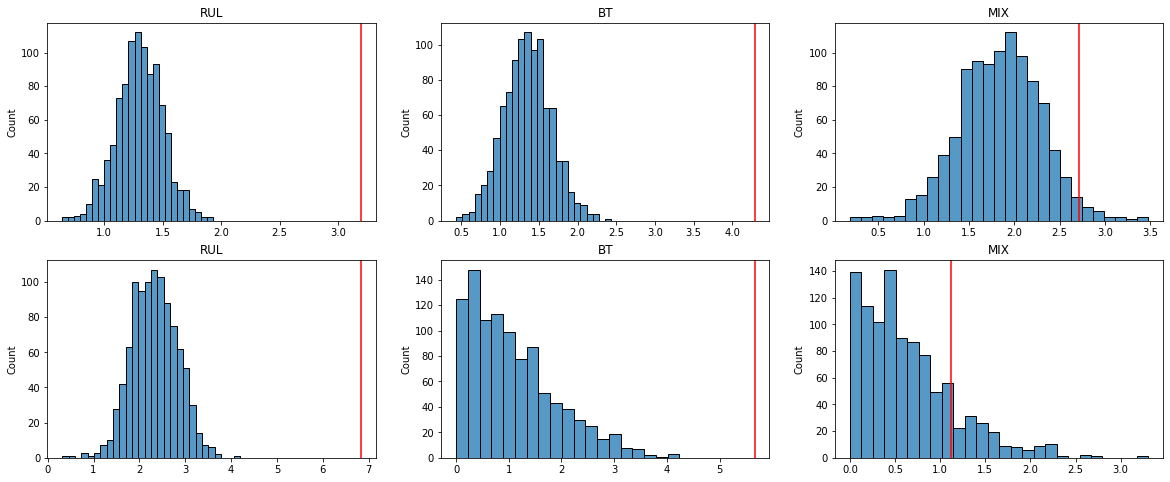

In [354]:
fig, axs = plt.subplot_mosaic("XYZ;ABC", figsize=(20,8))
figpl = ['X','A','Y','B', 'Z','C']
mypmnt = ['RUL','RUL', 'BT', 'BT', 'MIX', 'MIX']
for j in range(6):
    _ = sns.histplot(biglist3[j], ax=axs[figpl[j]])#here we just stored the permutations
    axs[figpl[j]].axvline(origvalues[j],0,10, color='red')#we use the real value from earlier
    axs[figpl[j]].set_title(mypmnt[j])

In [376]:
import statsmodels.api as sm


name = ['perm1', 'perm2']

biglist3=[]

for pp in range(3): #this is the placement 0 RUL 1 BT 2 MIX
    #for kk in range(2):#PC1 and PC2
        po = post_vol.iloc[np.where(post_vol['Record ID'].isin(efvol_sid_hamd2['Record ID'].iloc[np.where(efvol_sid_hamd2['pmnt']==pp)].unique()))].reset_index().copy()
        ba = basvol.iloc[np.where(basvol['Record ID'].isin(efvol_sid_hamd2['Record ID'].iloc[np.where(efvol_sid_hamd2['pmnt']==pp)].unique()))].reset_index().copy()


        #ba and po 
        
        perm1=[]
        perm2=[]
        for g in range(2):
            for k in range(1000):
                ix = np.random.permutation(po.shape[0])
                #ix=range(246)
                X_train = 2*(np.array(po.loc[:,mc])-np.array(ba.loc[ix,mc])[ix,:])/(np.array(po.loc[:,mc])+np.array(ba.loc[:,mc])[ix,:])

                #X_train = np.array(2*(po.loc[:,mc]-ba.loc[ix,mc])/(po.loc[:,mc]+ba.loc[ix,mc]))
                X_train

                pcacomp=2
                #eflist = np.append(np.array(range(0,85)),170)
                eflist = np.array(range(0,85))
                pcloads = np.empty((len(gli),0),float)
                pcs = []
                adat = []
                outcome = []
                strloads=[]
                recordids=[]
                sc=StandardScaler()
                X_train = sc.fit_transform(X_train)
                #X_train.std(axis=0)
                #Xlater = X_train.copy()
                #adat.append(Xlater)
                pca = PCA(n_components = pcacomp)
                X_train = pca.fit_transform(X_train)
                #rvalues.append(abs(pearsonr(pca.components_[kk,:],svec[gli])[0]))#abs is needed as the pc sign is not well defined
                #rvalues.append(abs(spearmanr(pca.components_[kk,:],svec[gli])[0]))#abs is needed as the pc sign is not well defined
                if (g==0): #fixing second PC2
                    res['perm1']=pca.components_[0,:]
                    res['perm2']=res[mypcs[2*pp+1]]
                else: #fixing PC1
                    res['perm1']=res[mypcs[2*pp]]
                    res['perm2']=pca.components_[1,:]
                
                #X=res[['absx','y','z','perm1','perm2']]
                X=res[['perm1','perm2','absx','y','z']]
                #X=res[['perm1','perm2']]
                #X=res[[name[kk],'absx','y','z']]
                y=res['sid']
                X = sm.add_constant(X)
                model = sm.OLS(y,X).fit()
                predictions = model.predict(X)
                if (g==0):
                    perm1.append(abs(model.tvalues[1]))
                else:
                    perm2.append(abs(model.tvalues[2]))

                #rvalues_real #we get the original
        biglist3.append(list(perm1))
        biglist3.append(list(perm2))
    

In [377]:
mypcs=['pc6','pc7','pc8','pc9','pc10','pc11']
origvalues =[]
for j in range(3):
    #for kk in range(2):
        #X=res[['absx','y','z',mypcs[2*j],mypcs[2*j+1]]]
        X=res[[mypcs[2*j],mypcs[2*j+1],'absx','y','z']]
        #X=res[[mypcs[2*j],mypcs[2*j+1]]]
        #X=res[[mypcs[2*j+kk],'absx','y','z']]
        y=res['sid']
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        predictions = model.predict(X)
        origvalues.append(abs(model.tvalues[1]))
        origvalues.append(abs(model.tvalues[2]))

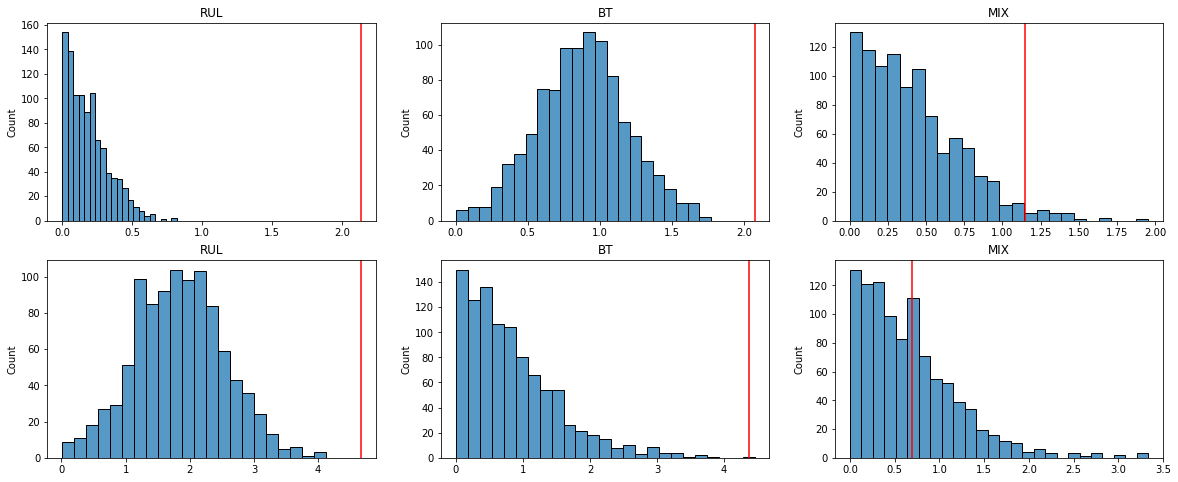

In [378]:
fig, axs = plt.subplot_mosaic("XYZ;ABC", figsize=(20,8))
figpl = ['X','A','Y','B', 'Z','C']
mypmnt = ['RUL','RUL', 'BT', 'BT', 'MIX', 'MIX']
for j in range(6):
    _ = sns.histplot(biglist3[j], ax=axs[figpl[j]])#here we just stored the permutations
    axs[figpl[j]].axvline(origvalues[j],0,10, color='red')#we use the real value from earlier
    axs[figpl[j]].set_title(mypmnt[j])

In [335]:
for i in range(6):
    print(1 - len(np.where(biglist3[i]<origvalues[i])[0])/1000)

0.0
0.0010000000000000009
0.0
0.0
0.019000000000000017
0.378


### EF permutation

In [336]:
#gli

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from scipy.stats import spearmanr

gli=np.array(range(0,85))
biglistEF=[]
#for k in range(2): #PC1 or PC2
for pp in range(3): #this is the placement 0 RUL 1 BT 2 MIX
    clist = gli
    pcacomp=2
    #eflist = np.append(np.array(range(0,85)),170)
    eflist = np.array(range(0,85))
    pcloads = np.empty((len(gli),0),float)
    pcs = []
    adat = []
    outcome = []
    strloads=[]
    recordids=[]
    perm1 = []
    perm2 = []
    Xlong=efvol_sid_hamd2[['Record ID', 'roi','ef_mix3','volume change','age', 'Hamd change percent','pmnt','nECT']].iloc[np.where(efvol_sid_hamd2['pmnt']==pp)]
    Xwide=pd.pivot(Xlong, index='Record ID', columns= 'roi', values=['ef_mix3','volume change'])
    Xw = Xwide.merge(Xlong[['Record ID', 'age', 'Hamd change percent','pmnt', 'nECT']].drop_duplicates(), on='Record ID').dropna()
    recordids.append(Xw.iloc[:,0].values)
    X=Xw.iloc[:,1:(Xw.shape[1]-4)].values
    X_train=X[:,clist]
    #y =Xw.iloc[:,(Xw.shape[1]-4):Xw.shape[1]].values
    sc=StandardScaler()
    X_train = sc.fit_transform(X_train)
    #X_train.std(axis=0)
    #Xlater = X_train.copy()
    #adat.append(Xlater)
    pca = PCA(n_components = pcacomp)
    X_train = pca.fit_transform(X_train)
    #rvalues_real=abs(pearsonr(pca.components_[k,:],svec[gli])[0])
    #rvalues_real=abs(spearmanr(pca.components_[k,:],svec[gli])[0])
    res['perm1']=pca.components_[0,:]
    res['perm2']=pca.components_[1,:]
    p1fix=pca.components_[0,:]
    p2fix=pca.components_[1,:]
    
    XX=res[['perm1','perm2','absx','y','z']]
    y=res['sid']
    XX = sm.add_constant(XX)
    model = sm.OLS(y,XX).fit()
    predictions = model.predict(XX)
    perm10=(abs(model.tvalues[1]))
    perm20=(abs(model.tvalues[2]))
    rvalues = []
    for g in range(2):
        for j in range(1000):
            X_train=X[:,clist]
            NR = X_train.shape[1]
            for i in range(NR):
                ix = np.random.permutation(X_train.shape[0])
                X_train[:,i] = X_train[ix,i]
            sc=StandardScaler()
            X_train = sc.fit_transform(X_train)
            #X_train.std(axis=0)
            #Xlater = X_train.copy()
            #adat.append(Xlater)
            pca = PCA(n_components = pcacomp)
            X_train = pca.fit_transform(X_train)
            #rvalues.append(abs(spearmanr(pca.components_[k,:],svec[gli])[0]))#pc is well defined only to a -1 so we need absolute
            #res['perm1']=pca.components_[0,:]
            if (g==0):
                res['perm2']=p2fix
                res['perm1']=pca.components_[0,:]
            else:
                res['perm1']=p1fix
                res['perm2']=pca.components_[1,:]
            #X=res[['absx','y','z','perm1','perm2']]
            XX=res[['perm1','perm2','absx','y','z']]
            #XX=res[['perm1','perm2']]
            y=res['sid']
            XX = sm.add_constant(XX)
            model = sm.OLS(y,XX).fit()
            predictions = model.predict(XX)
            if (g==0):
                perm1.append(abs(model.tvalues[1]))
            else:
                perm2.append(abs(model.tvalues[2]))

        #pca.components_[k,:]
    #biglistEF.append(list(rvalues))
    #biglistEF.append(rvalues_real)
    biglistEF.append(list(perm1))
    biglistEF.append(perm10)
    biglistEF.append(list(perm2))
    biglistEF.append(perm20)

/tmp/ipykernel_25/3005012483.py:27: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  Xw = Xwide.merge(Xlong[['Record ID', 'age', 'Hamd change percent','pmnt', 'nECT']].drop_duplicates(), on='Record ID').dropna()
/tmp/ipykernel_25/3005012483.py:27: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  Xw = Xwide.merge(Xlong[['Record ID', 'age', 'Hamd change percent','pmnt', 'nECT']].drop_duplicates(), on='Record ID').dropna()
/tmp/ipykernel_25/3005012483.py:27: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  Xw = Xwide.merge(Xlong[['Record ID', 'age', 'Hamd change percent','pmnt', 'nECT']].drop_duplicates(), on='Record ID').dropna()


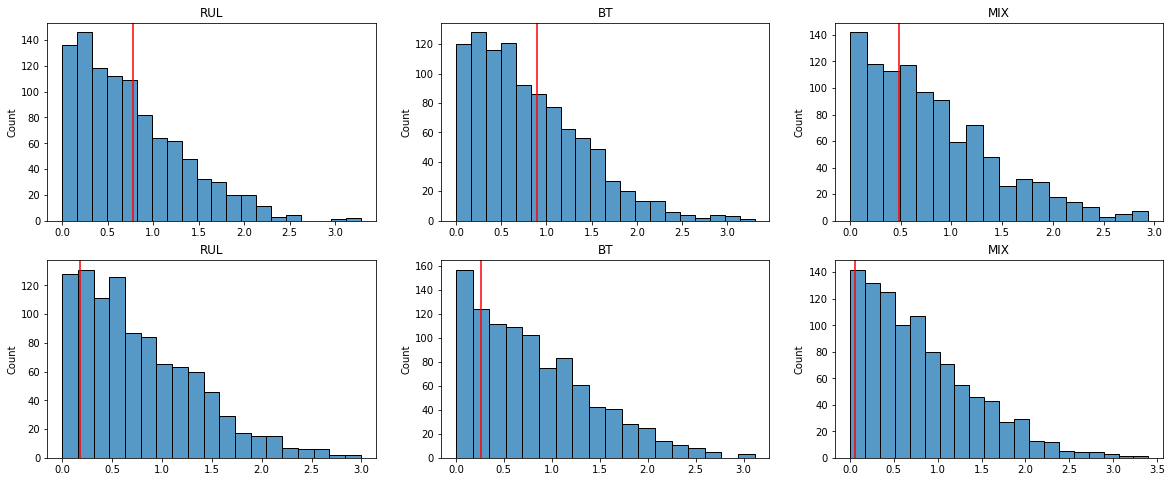

In [337]:
fig, axs = plt.subplot_mosaic("XYZ;ABC", figsize=(20,8))
figpl = ['X','A','Y','B', 'Z','C']
mypmnt = ['RUL','RUL', 'BT', 'BT', 'MIX', 'MIX']
for j in range(6):
    _ = sns.histplot(biglistEF[2*j], ax=axs[figpl[j]])#here we just stored the permutations
    axs[figpl[j]].axvline(biglistEF[2*j+1],0,10, color='red')#we use the real value from earlier
    axs[figpl[j]].set_title(mypmnt[j])